In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from scipy import interpolate, stats
import pandas as pd

In [33]:
data = pd.read_csv(r"C:\Users\Edwin\Downloads\test_df")
data = data.drop(data.index[0]) # drop dumb header

# pull data
pfh = pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[1:-1].tolist()
ethanol = pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[1:-1].tolist()
absorbance = pd.to_numeric(data['400.0nm'] , errors='coerce')[1:-1].tolist()
len(pfh)

202

In [3]:
def remove_visual_outliers(x, y, z, z_score_threshold = 3):
    """This is not a to remove statistical outliers, only to remove values which present. Outliers will be 
    removed based on the data of z and subsequently from x and y given the same indexes of entries. Inputs must be nparrays"""

    z_array = np.asarray(z)
    z_scores = np.abs(stats.zscore(np.asarray(z)))
    threshold = z_score_threshold
    index_to_remove = np.where(z_scores > threshold)[0] # must be in ascending order
    
    x = x.copy()
    y = y.copy()
    z = z.copy()
    
    for index in reversed(index_to_remove): # reveresed to perserve index
        del x[index]
        del y[index]
        del z[index]
    
    xyz_array = [x,y,z]
    return xyz_array


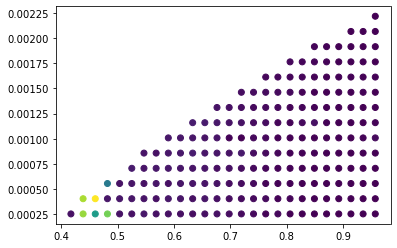

In [13]:
x=ethanol
y=pfh
z=absorbance
# xyz=remove_visual_outliers(x,y,z,2)
# x_out=xyz[0]
# y_out=xyz[1]
# z_out=xyz[2]

plt.scatter(x,y,c=z)
# plt.scatter(x_out, y_out, c= z_out)

In [26]:
len(x),len(y)

(203, 203)

In [34]:
x1_training = x #[0,  2,  4,  6,  8, 10, 12, 14, 16,  0,  2,  4,  6,  8, 10, 12, 14, 16]
x2_training = y #[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
x_training = np.array([[x,y] for x,y in zip(x1_training,x2_training)])
y_observation = z #np.array([-54,-60,-62,-64,-66,-68,-70,-72,-74,-60,-62,-64,-66,-68,-70,-72,-74,-76])

# look to optimze this?
kernal = C(1, (1e-1, 1e3)) * RBF(10, (1e-3, 1e3))
gp_model = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
gp_model.fit(x_training, y_observation)
gp_model.predict([[1,2]])

array([0.07752217])

In [35]:
# here is where I am having the most trouble
x1_test = np.linspace(min(x1_training), max(x1_training)) # min to max range of the x1 values,linspace always amkes 50 requal spacing
x2_test = np.linspace(min(x2_training), max(x2_training))
x1x2 = np.array(list(product(x1_test, x2_test))) # both meshes without using np.meshgrid - dont really understand 100%
y_pred, MSE = gp_model.predict(x1x2, return_std=True) # find the interpolation of the mesh, my issue is that can we contain it, i dont like extrpolation
X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50) # grab the seperate meshes 
Zp = np.reshape(y_pred,(50,50))

In [36]:
# y_pred_of_initial_training = gp_model.predict(x_training)
# y_pred_of_initial_training, y_observation # can compare these two, but should be plotting the obercation

0.04245938393190056


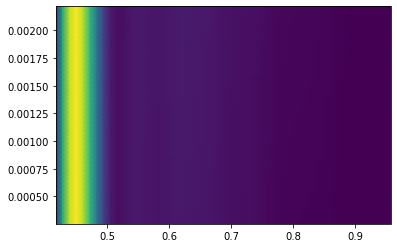

In [38]:
fig, ax = plt.subplots()
vmin = np.amin(Zp) # not sure 100 about where these vmin should come frm
vmax = np.amax(Zp)
print(vmin)
norm=colors.Normalize(vmin=vmin, vmax=vmax)
mappable = ax.pcolormesh(X0p, X1p, Zp, norm = norm, shading = 'gouraud')


# plt.scatter(x_training[:,0], x_training[:,1], c = y_observation, norm = norm, edgecolors='k') # scatter should be of the training data run through again
# plt.xlim([0.4,1])
# plt.ylim([0,0.0025])